In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob 

sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders_v2 import *

2023-10-15 18:27:05.578049: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

In [3]:
wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [4]:
path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/'

In [5]:
files_weekly_anoms = np.sort(glob.glob(f'{path_weekly_anoms}/*.nc'))

In [6]:
ifile = 4

In [7]:
file_temp = files_weekly_anoms[ifile]
dataset = xr.open_dataset(file_temp)
var_name = list(dataset.data_vars.keys())[0]
print(file_temp,var_name)
dataset = dataset.load()

/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/OHC200_SODA.nc ocean_heat_content_anomalies


In [8]:
name_var = file_temp.split('/')[-1][:-3]

In [9]:
### Find and drop useless (always zero, pixels)

In [10]:
flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
nan_mask = flattened_da.isnull().all(dim='time')
# nan_mask = flattened_da.isnull().any(dim='time')
where_nonan = np.where(nan_mask==False)[0]
flattened_nonan = flattened_da[:,where_nonan]
flattened_nonan = flattened_nonan.fillna(0)

In [11]:
# create pca object
pca_obj = PCA(6, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(flattened_nonan)

# transform era5 data with pca
transformed_da = pca_obj.transform(flattened_nonan)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')

Variance explained: [10.12835491  4.44694789  3.95132949  3.11441671  2.99961195  2.33323858]
Cumulative sum of variance explained for EOF1 and EOF2: [10.12835491 14.5753028  18.52663229 21.641049   24.64066095 26.97389953]


In [12]:
transformed_da = pd.DataFrame(transformed_da,index = dataset.time)

In [13]:
# For each PC, plot map and plot anomalies in WR histogram for each week

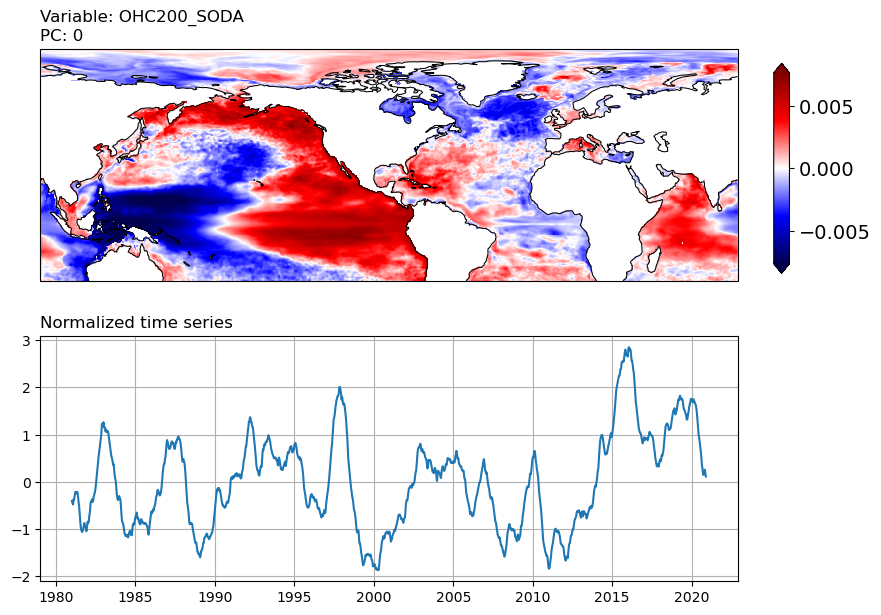

In [24]:
ipc = 0

pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
# flattened_nonan.isel(time=0).values = pca_obj.components_[0]
pc_flattened_nonan.values = pca_obj.components_[ipc]
pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
array_temp = copy.deepcopy(pc_flattened.values)
array_temp[where_nonan] = pc_flattened_nonan.values
pc_flattened.values  = array_temp
unstacked_pc = pc_flattened.unstack('flat')

##########PLOT MAP #####################
symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

# print(vmax,vmin)
cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
    unstacked_pc.values,cmap='seismic',
    transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)

plt.xlim()

plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

cbar_ax = fig.add_axes([0.94, 0.55, 0.0175, 0.3])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=14)
# cbar.set_label(trend.units, fontsize=14)

ax2 = fig.add_subplot(212)
ax2.plot(transformed_da[ipc])
ax2.grid()
plt.title(f'Normalized time series',loc='left')

plt.show()

In [25]:
df_wr_temp = df_shifts['week0'].dropna()
mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

In [26]:
normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))
res = 0.4
mid_bins = np.arange(-1+res/2,1,res)

In [27]:
week = 1
df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

In [28]:
prob2d = np.zeros([5,len(mid_bins)])
hist_pc_ranges = []
for ibin,bin_center in enumerate(mid_bins):
    # print(bin_center)
    df_temp = df_pc_wr[(df_pc_wr[ipc]>=bin_center-res/2)&(df_pc_wr[ipc]<=bin_center+res/2)][f'week{week}']
    # print(len(df_temp))
    hist_pc_ranges.append(len(df_temp))
    hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
    hist_temp = hist_temp/np.sum(hist_temp)
    diff_temp = mean_hist_wrs-hist_temp
    prob2d[:,ibin] = diff_temp

In [29]:
names_wr = ['WR1: IH','WR2: PH', 'WR3: IL', 'WR4: PL', 'WR5: Clima']

In [30]:
avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)

/glade/scratch/jhayron/ipykernel_29080/2596704146.py:11: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)


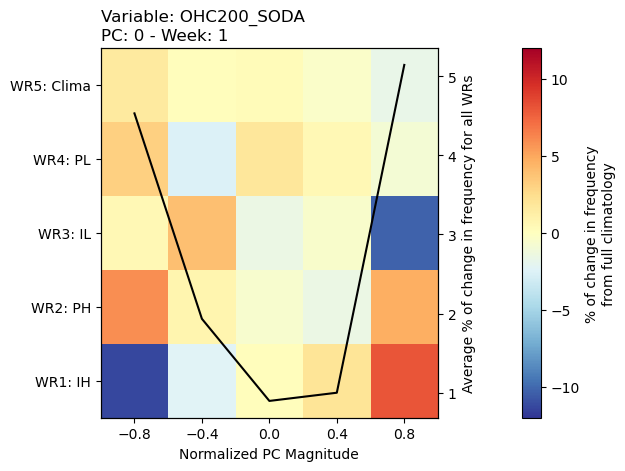

In [31]:
fig, ax1 = plt.subplots()
cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-12,vmax=12,cmap='RdYlBu_r')

ax1.set_xticks(mid_bins)
ax1.set_xlabel('Normalized PC Magnitude')

ax2 = ax1.twinx()
ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
ax2.set_ylabel('Average % of change in frequency for all WRs')

cbar = plt.colorbar(cm,pad=0.17)
cbar.set_label('% of change in frequency\nfrom full climatology')

plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
plt.show()

#### Plot for each week ####

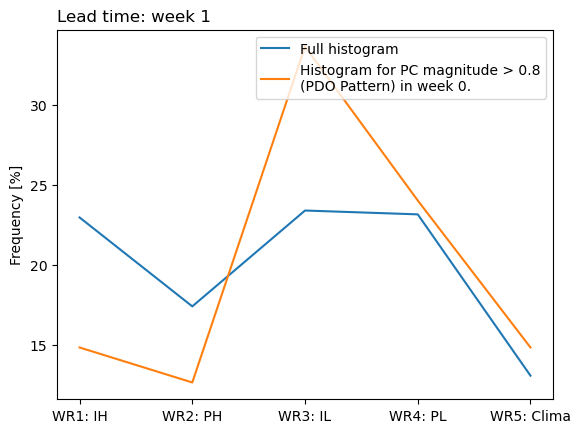

In [32]:
plt.close('all')
plt.plot(names_wr,mean_hist_wrs*100,label = 'Full histogram')
plt.plot(names_wr,hist_temp*100,label = 'Histogram for PC magnitude > 0.8\n(PDO Pattern) in week 0.')
plt.ylabel('Frequency [%]')
plt.legend()
plt.title(f'Lead time: week {week}',loc='left')
# plt.xticks()
plt.show()

# Iterate through weeks

In [33]:
names_wr = ['WR1: IH','WR2: PH', 'WR3: IL', 'WR4: PL', 'WR5: Clima']

In [34]:
path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/pc{ipc}/'

In [35]:
try: os.mkdir(path_figures)
except: pass

try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/')
except: pass

In [40]:
avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])

for week in [1,2,3,4,5,6,7,8]:
    df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

    prob2d = np.zeros([5,len(mid_bins)])
    for ibin,bin_center in enumerate(mid_bins):
        df_temp = df_pc_wr[(df_pc_wr[ipc]>=bin_center-res/2)&(df_pc_wr[ipc]<=bin_center+res/2)][f'week{week}']
        hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
        hist_temp = hist_temp/np.sum(hist_temp)
        diff_temp = mean_hist_wrs-hist_temp
        prob2d[:,ibin] = diff_temp
    avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
    avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week
    
    ### Plot for week ###
    fig, ax1 = plt.subplots()
    cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-35,vmax=35,cmap='RdYlBu_r')

    ax1.set_xticks(mid_bins)
    ax1.set_xlabel('Normalized PC Magnitude')

    ax2 = ax1.twinx()
    ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
    ax2.set_ylabel('Average % of change in frequency for all WRs')

    cbar = plt.colorbar(cm,pad=0.17)
    cbar.set_label('% of change in frequency\nfrom full climatology')

    plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
    plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
    plt.close('all')
    
fig, ax1 = plt.subplots()
cm = ax1.pcolormesh([1,2,3,4,5,6,7,8],mid_bins,avg_change_bins_weeks*100,
                    vmin=0,vmax=6,cmap='YlOrRd')

ax1.set_yticks(mid_bins)
ax1.set_xlabel('Lead time week')
ax1.set_ylabel('Normalized PC Magnitude')

# ax2 = ax1.twinx()
# ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
# ax2.set_ylabel('Average % of change in frequency for all WRs')

cbar = plt.colorbar(cm)
cbar.set_label('Average % absolute change in frequency')

plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/abs_chng_freq_pc{ipc}.png',
            bbox_inches='tight')
plt.close('all')

/glade/scratch/jhayron/ipykernel_29080/2911666102.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_29080/2911666102.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_29080/2911666102.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.color

# Iterate through PCs

In [368]:
df_wr_temp = df_shifts['week0'].dropna()
mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

In [370]:
try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/')
except: pass

transformed_da.to_csv(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/PC_{name_var}.csv')

for ipc in range(6):
    ##########Unstack PC #####################
    pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
    # flattened_nonan.isel(time=0).values = pca_obj.components_[0]
    pc_flattened_nonan.values = pca_obj.components_[ipc]
    pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
    array_temp = copy.deepcopy(pc_flattened.values)
    array_temp[where_nonan] = pc_flattened_nonan.values
    pc_flattened.values  = array_temp
    unstacked_pc = pc_flattened.unstack('flat')

    ##########PLOT MAP #####################
    symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

    # print(vmax,vmin)
    cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
        unstacked_pc.values,cmap='seismic',
        transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.margins(x=0, y=0)

    plt.xlim()

    plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

    cbar_ax = fig.add_axes([0.17, 0.275, 0.7, 0.0175])
    cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal', extend='both')
    cbar.ax.tick_params(labelsize=14)
    # cbar.set_label(trend.units, fontsize=14)
    ax2 = fig.add_subplot(212)
    ax2.plot(transformed_da[ipc])
    ax2.grid()
    plt.title(f'Normalized time series',loc='left')
    
    plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/map_pc{ipc}.png',
            bbox_inches='tight')
    plt.close('all')
    ##########Normalize PC #####################
    normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))
    # plt.plot(normalized_pc)
    # plt.show()
    # plt.close('all')
    ##########Get conditional histogram for each bin within PC #####################
    res = 0.4
    mid_bins = np.arange(-1.+res/2,1.1,res)
    
    avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
    
    path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/pc{ipc}/'
    try: os.mkdir(path_figures)
    except: pass

    for week in [1,2,3,4,5,6,7,8]:
        df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

        prob2d = np.zeros([5,len(mid_bins)])
        for ibin,bin_center in enumerate(mid_bins):
            df_temp = df_pc_wr[(df_pc_wr[ipc]>=bin_center-res/2)&(df_pc_wr[ipc]<=bin_center+res/2)][f'week{week}']
            hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
            hist_temp = hist_temp/np.sum(hist_temp)
            diff_temp = mean_hist_wrs-hist_temp
            prob2d[:,ibin] = diff_temp
        avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
        avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week

        ### Plot for week ###
        fig, ax1 = plt.subplots()
        cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-10,vmax=10,cmap='RdYlBu_r')

        ax1.set_xticks(mid_bins)
        ax1.set_xlabel('Normalized PC Magnitude')

        ax2 = ax1.twinx()
        ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
        ax2.set_ylabel('Average % of change in frequency for all WRs')

        cbar = plt.colorbar(cm,pad=0.17)
        cbar.set_label('% of change in frequency\nfrom full climatology')

        plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
        plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
        plt.close('all')
    
    ##########Plot average change in frequency for each week and bin #####################
    fig, ax1 = plt.subplots()
    cm = ax1.pcolormesh([1,2,3,4,5,6,7,8],mid_bins,avg_change_bins_weeks*100,
                        vmin=0,cmap='YlOrRd')

    ax1.set_yticks(mid_bins)
    ax1.set_xlabel('Lead time week')
    ax1.set_ylabel('Normalized PC Magnitude')

    # ax2 = ax1.twinx()
    # ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
    # ax2.set_ylabel('Average % of change in frequency for all WRs')

    cbar = plt.colorbar(cm)
    cbar.set_label('Average % absolute change in frequency')

    plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
    plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/abs_chng_freq_pc{ipc}.png',
                bbox_inches='tight')
    plt.close('all')